# Signal separation between amorphous and crystalline phases



In [1]:
%matplotlib nbagg

In [2]:
import time
import numpy
from matplotlib.pyplot import subplots
import fabio
import pyFAI

from pyFAI.gui import jupyter
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
from silx.resources import ExternalResources

start_time = time.perf_counter()
downloader = ExternalResources("pyfai", "http://www.silx.org/pub/pyFAI/testimages")
image_file = downloader.getfile("Pilatus6M.cbf")
geometry_file = downloader.getfile("Pilatus6M.poni")

fimg = fabio.open(image_file)
img = fimg.data
print(f"Using pyFAI version {pyFAI.version}")
#print(fabio.open(image_file).header["_array_data.header_contents"])

Using pyFAI version 0.21.0-dev0


In [3]:
# ai = AzimuthalIntegrator(detector="Pilatus6M")
# ai.setFit2D(300, 1230.10, 1310.50)

ai = pyFAI.load(geometry_file)
ai.wavelength = 1.0332e-10
ai.detector = pyFAI.detector_factory("Pilatus6M")
ai

Detector Pilatus 6M	 PixelSize= 1.720e-04, 1.720e-04 m
Wavelength= 1.033200e-10m
SampleDetDist= 3.000000e-01m	PONI= 2.254060e-01, 2.285880e-01m	rot1=0.000000  rot2= 0.000000  rot3= 0.000000 rad
DirectBeamDist= 300.000mm	Center: x=1329.000, y=1310.500 pix	Tilt=0.000 deg  tiltPlanRotation= 0.000 deg

<IPython.core.display.Javascript object>


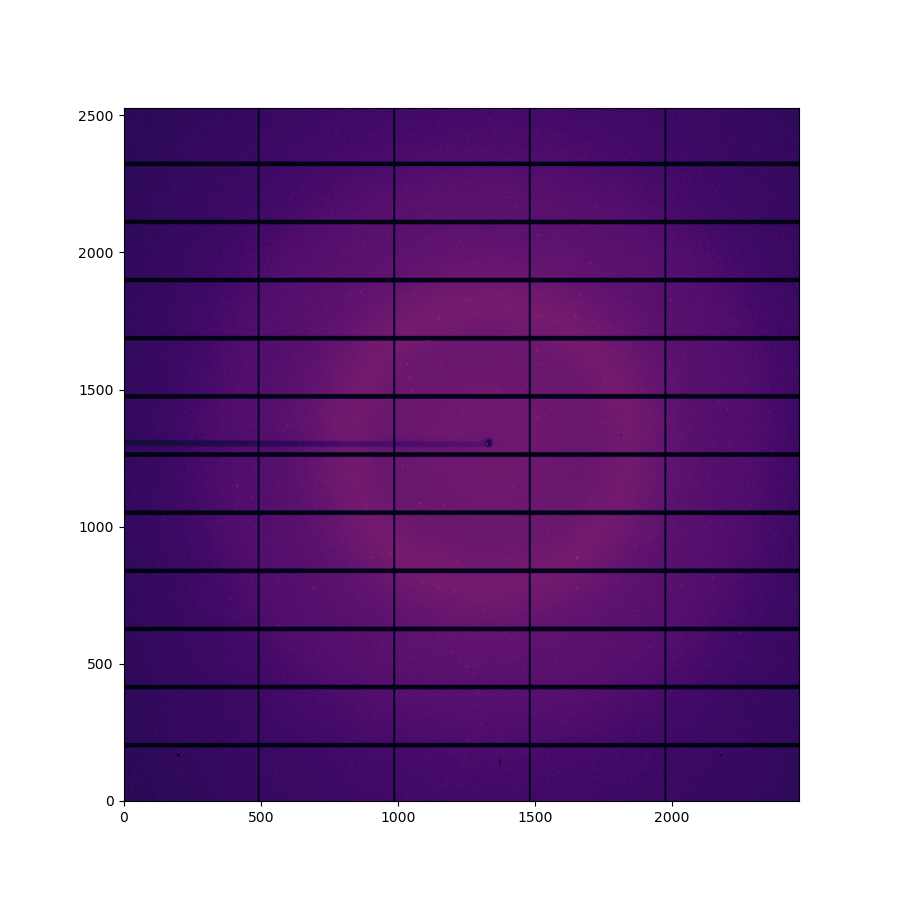

In [4]:
fig,ax = subplots(figsize=(9,9))
jupyter.display(img, ax=ax)
pass

## 0. 1D and 2D integration

<IPython.core.display.Javascript object>


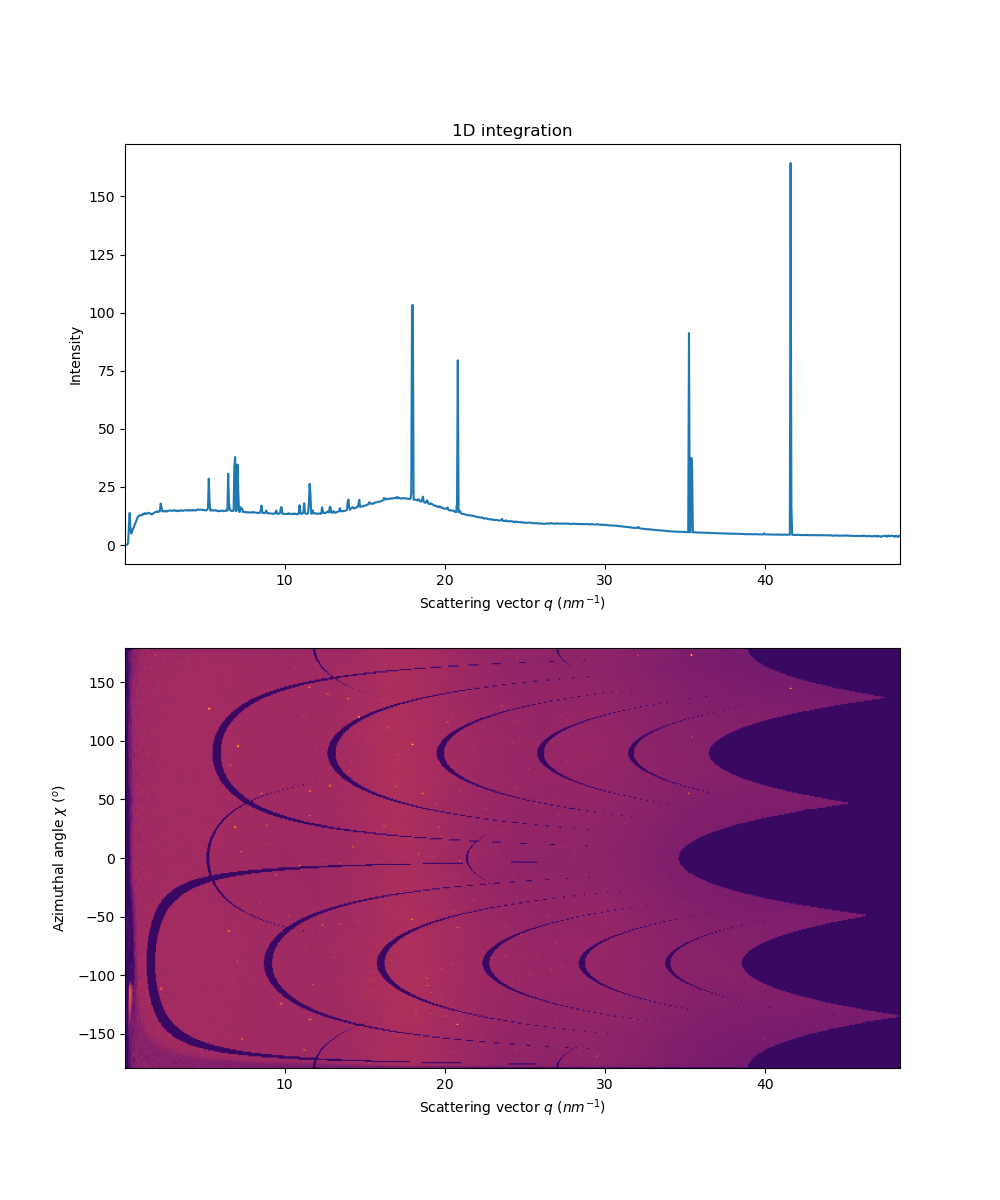

  File "<ipython-input-5-0a6e763f5841>", line 5, in <module>
    int2 = ai.integrate2d(img, 1000, method=method)


In [5]:
fig,ax = subplots(2, figsize=(10,12))
method=("full","csr","cython")
int1 = ai.integrate1d(img, 1000, method=method)
jupyter.plot1d(int1, ax=ax[0])
int2 = ai.integrate2d(img, 1000, method=method)
jupyter.plot2d(int2, ax=ax[1])
ax[0].set_xlim(int2.radial.min(), int2.radial.max())
pass

## 1. Separation based on 2D integration

Two methods are readily available in pyFAI, they perform filtering the 2D regrouped image along a vertical axis:
* median filtering: simple median along azimuthal angle
* sigma clipping: iterative removal of all pixels above n standard deviation

The drawback is in the 2D integration: costly in time and smears pixel together.

<IPython.core.display.Javascript object>


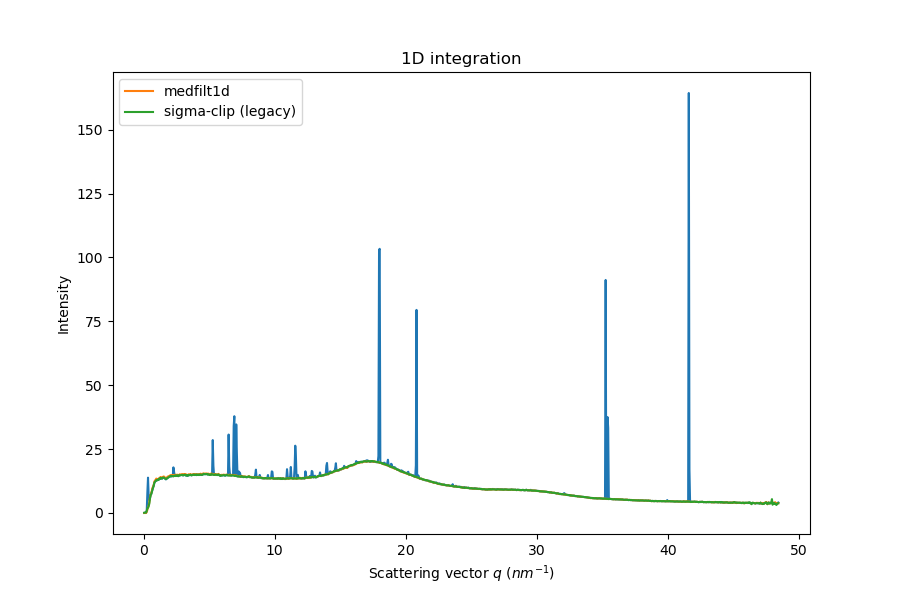

  File "/usr/lib/python3/dist-packages/pyFAI/azimuthalIntegrator.py", line 2723, in medfilt1d
    res2d = self.integrate2d(data, npt_rad, npt_azim, mask=mask,
  File "/usr/lib/python3/dist-packages/pyFAI/azimuthalIntegrator.py", line 2868, in _sigma_clip_legacy
    res2d = self.integrate2d(data, npt_rad, npt_azim, mask=mask,


CPU times: user 457 ms, sys: 33.4 ms, total: 491 ms
Wall time: 490 ms
CPU times: user 444 ms, sys: 56.4 ms, total: 500 ms
Wall time: 499 ms


In [6]:
fig,ax = subplots(1,1, figsize=(9,6))
int1 = ai.integrate1d(img, 1000, method=method)
jupyter.plot1d(int1, ax=ax)
%time mf1 = ai.medfilt1d(img, 1000, method=method)
%time sc2 = ai.sigma_clip(img, 1000, method=method, thres=5, max_iter=5)
ax.plot(mf1.radial, mf1.intensity, label="medfilt1d")
ax.plot(sc2.radial, sc2.intensity, label="sigma-clip (legacy)")
ax.legend()
pass

## 2. Separation based on 1D integration:

1D CSR integrator contain all the information to perform the sigma-clipping. This has been implemented in OpenCL and can be performed up to thousands of times per second.

* Available using OpenCL (no cython yet)
* Presentation of how it can be implemented is explained later in the demonstration

<IPython.core.display.Javascript object>


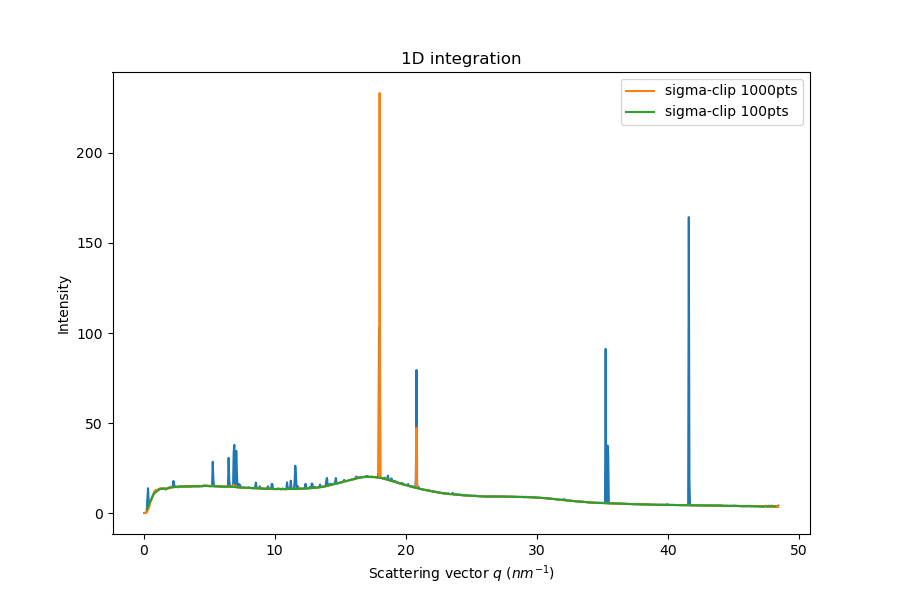

CPU times: user 742 ms, sys: 104 ms, total: 846 ms
Wall time: 368 ms
CPU times: user 242 ms, sys: 20.2 ms, total: 263 ms
Wall time: 262 ms


In [7]:
fig,ax = subplots(1,1, figsize=(9,6))
int1 = ai.integrate1d(img, 1000, method=method)
jupyter.plot1d(int1, ax=ax)
%time sc1000 = ai.sigma_clip_ng(img, 1000, method=("no","csr","opencl"), thres=5, max_iter=5, error_model="poisson")
%time sc100 = ai.sigma_clip_ng(img, 100, method=("no","csr","opencl"), thres=5, max_iter=5, error_model="poisson")
ax.plot(sc1000.radial, sc1000.intensity, label="sigma-clip 1000pts")
ax.plot(sc100.radial, sc100.intensity, label="sigma-clip 100pts")
ax.legend()
pass

## 3. Rebuild the isotropic and anisotropic contribution

Isotropic images are simply obtained from bilinear interpolation from 1D curves.

<IPython.core.display.Javascript object>


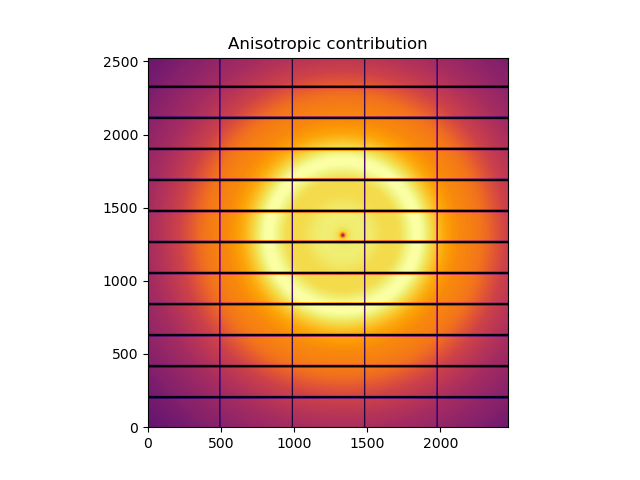

In [8]:
# Rebuild an image from the integrated curve:
isotropic = ai.calcfrom1d(sc100.radial, sc100.intensity, dim1_unit=sc100.unit, mask = ai.detector.mask)
jupyter.display(isotropic, label="Anisotropic contribution")
pass

<IPython.core.display.Javascript object>


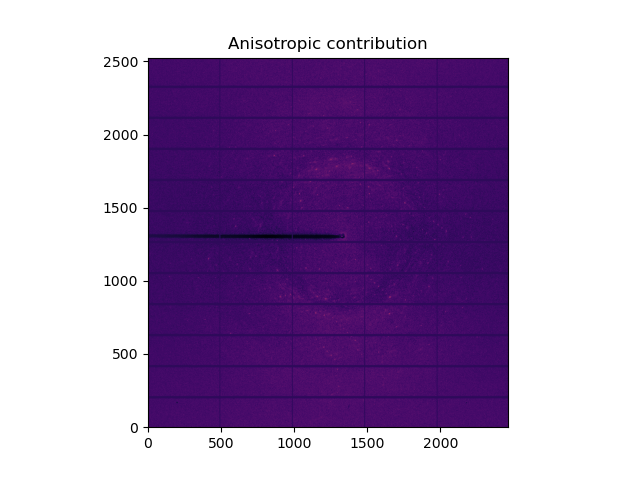

In [9]:
aniso = img - isotropic
jupyter.display(aniso, label="Anisotropic contribution")
pass

<IPython.core.display.Javascript object>


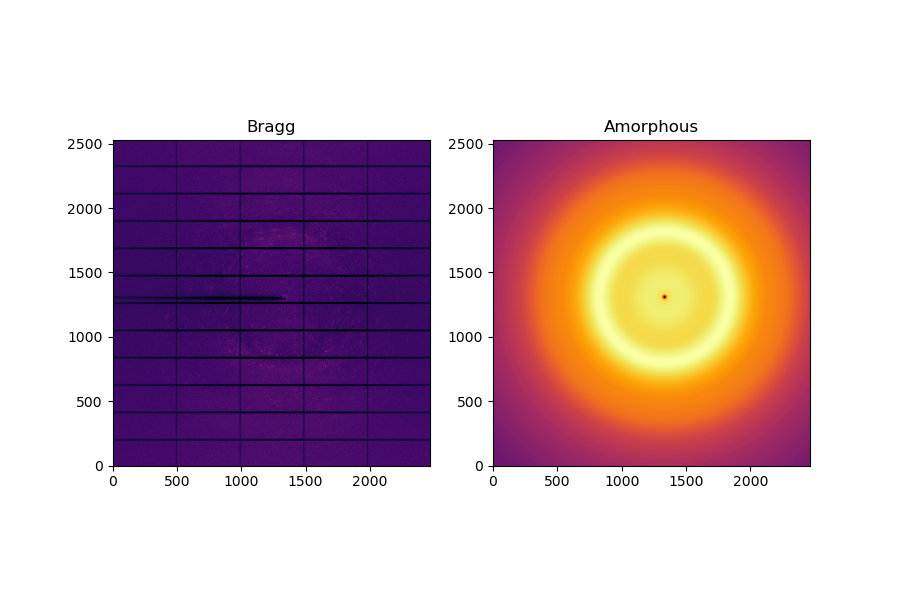

In [10]:
#This can be simplified (using median filtering)
bragg, amorphous = ai.separate(img)

fig,ax = subplots(1, 2, figsize=(9,6))
jupyter.display(bragg, label="Bragg", ax=ax[0])
jupyter.display(amorphous, label="Amorphous", ax=ax[1])
pass

## 4. Implementation of sigma-clipping using pure 1D integrators.

This is a workaround until it is implemented in pyFAI. The procedure mimics what is running in OpenCL.

In [11]:
def sigma_clip_ng(ai, img, npt, method, unit="q_nm^-1", error_model=None, thres=5, max_iter=5):
    img = img.astype(numpy.float32) #also explicit copy
    if error_model!="poisson":
        raise RuntimeError("Only Poissonian detector are supported for now")
    for i in range(max_iter):
        variance = img #enforce Poisson lay
        res1d = ai.integrate1d(img, npt, variance=variance, method=method, unit=unit)
        new_signal = ai.calcfrom1d(res1d.radial, res1d.intensity, dim1_unit=res1d.unit)
        new_variance = ai.calcfrom1d(res1d.radial, res1d.intensity, dim1_unit=res1d.unit)
        discard = abs(img-new_signal)>thres*new_variance
        if discard.sum() == 0: break
        img[discard] = numpy.NaN
    return res1d

<IPython.core.display.Javascript object>


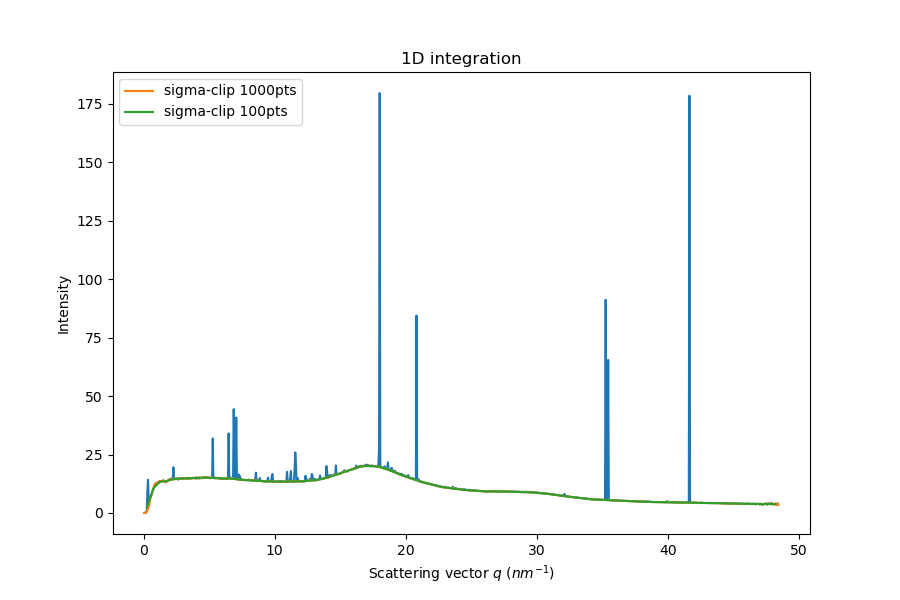

CPU times: user 2.8 s, sys: 1.58 s, total: 4.37 s
Wall time: 831 ms
CPU times: user 2.09 s, sys: 1.37 s, total: 3.46 s
Wall time: 707 ms


In [12]:
fig,ax = subplots(1,1, figsize=(9,6))
method = ("no","csr","cython")
int1 = ai.integrate1d(img, 1000, method=method)
jupyter.plot1d(int1, ax=ax)
%time sc1000 = sigma_clip_ng(ai, img, 1000, method=method, thres=5, max_iter=5, error_model="poisson")
%time sc100 = sigma_clip_ng(ai, img, 100, method=method, thres=5, max_iter=5, error_model="poisson")
ax.plot(sc1000.radial, sc1000.intensity, label="sigma-clip 1000pts")
ax.plot(sc100.radial, sc100.intensity, label="sigma-clip 100pts")
ax.legend()
pass

## 5. Towards lossy compression of single crystal diffraction data

For now only available as OpenCL code. 

Also available as command line tool, see `man sparsify-Bragg`:

This 6 Mpix image can be summarized by:
* 2000 pixels with signal above the background
* 100 radial bins with intensity and associated deviation

In [13]:
from pyFAI.opencl.peak_finder import OCL_PeakFinder
method = sc100.method
print(method)
lut = ai.engines[method].engine.lut
#print(lut) # this is the stored transformation matrix
peak_finder = OCL_PeakFinder(lut, 
                             image_size=numpy.prod(ai.detector.shape),
                             unit=sc100.unit,
                             bin_centers=sc100.radial,
                             radius=ai.array_from_unit(sc100.unit),
                             mask=ai.detector.mask)

%time sep = peak_finder(img, error_model="poisson")
print(f"Number of Bragg pixels found: {len(sep.index)}")

IntegrationMethod(1d int, no split, CSR, cython)
CPU times: user 1.61 ms, sys: 730 µs, total: 2.34 ms
Wall time: 28.2 ms
Number of brag pixel found: 19233


In [14]:
%%time
# Rebuild the image with noise
bg_avg = ai.calcfrom1d(sep.radius, sep.background_avg, dim1_unit=sc100.unit)
bg_std = ai.calcfrom1d(sep.radius, sep.background_std, dim1_unit=sc100.unit)
restored = numpy.random.normal(bg_avg, bg_std)
restored[numpy.where(ai.detector.mask)] = -1
restored_flat = restored.ravel()
restored_flat[sep.index] = sep.intensity
restored = numpy.round(restored).astype(numpy.int32)

CPU times: user 349 ms, sys: 27.6 ms, total: 377 ms
Wall time: 376 ms


<IPython.core.display.Javascript object>


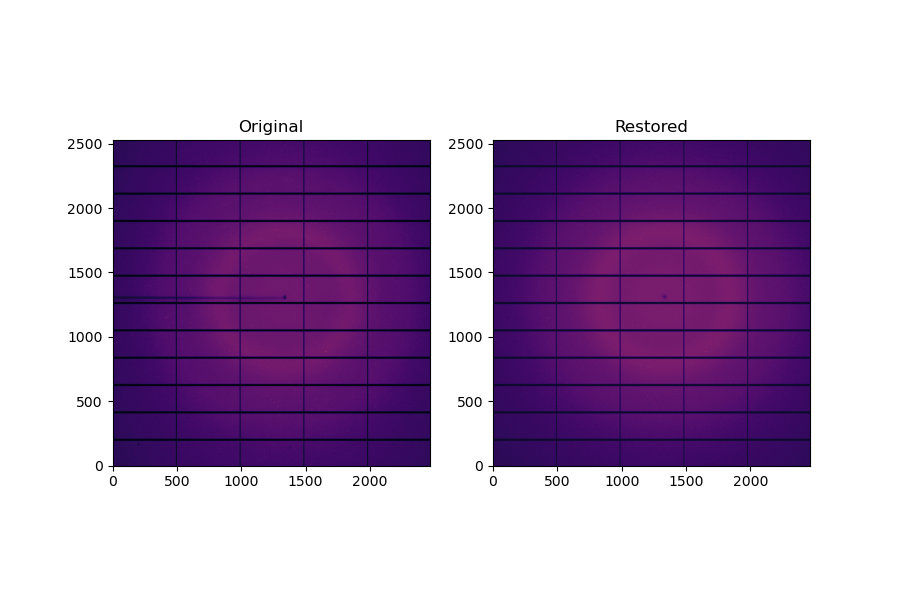

In [15]:
fig,ax = subplots(1, 2, figsize=(9,6))
jupyter.display(img, label="Original", ax=ax[0])
jupyter.display(restored, label="Restored", ax=ax[1])
pass

In [16]:
raw_size = img.nbytes
cmp_size = sep.index.nbytes + sep.intensity.nbytes + sep.background_avg.nbytes + sep.background_std.nbytes
print(f"The compression ratio would be : {raw_size/cmp_size:.3f}x")

The compression ratio would be : 160.968x


## 6. Conclusion

This tutorial explains how single crystal diffraction images can be treated to separate the amorphous content from Bragg peaks.
The first method has extensively been described in `J Kieffer & J.P. Wright; Powder Diffraction (2013) 28 (S2), pp339-350`
Subsequent ones have been developed with Gavin Vaughan (ESRF ID15) and Daniele De Sanctis (ESRF ID29).
Those methods open the door to lossy compression in the world of single crystal diffraction with compression rates above 100x which makes them appealing for serial-crystallography applications where bandwidth is critical. 
First experimentation shows a limited degradation of 

In [17]:
print(f"Total execution time: {time.perf_counter()-start_time:.3f}s ")

Total execution time: 9.682s 
